# Проект для «Викишоп»

In [14]:
import random

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from scipy.stats import uniform
from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostClassifier

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [15]:
df = pd.read_csv("data/toxic_comments.csv", index_col=0)
df.sample(3)

,text,toxic
74995,"""\n\nWhat you've been told seems to be erroneo...",0
112381,"""\n\nI've added the """""""" template to the artic...",0
13200,"Criticism is supposed to be critical, that doe...",0


In [16]:
df["toxic"].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

In [17]:
df.shape

(159292, 2)

Имеется серьезный дисбаланс классов, поэтому необходимо использовать соответствующие алгоритмы.

## Предсказываем с помощью эмбедингов.

Для классификации будем использовать эмбединги, полученные из модели bert-large-uncased. Возьмем предобученную модель из библиотеки transformers и напишим свой дочерний класс Dataset библиотеки torch.

In [18]:
tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")

model = AutoModel.from_pretrained("unitary/toxic-bert").to("cuda:0")


Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
df.reset_index(drop=True, inplace=True)

In [20]:
class BuildDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.list_text_size = []
        self.max_len = 512

    def set_len_text(self):
        self.list_text_size = self.df["text"].apply(
            lambda x: len(tokenizer.encode(x, add_special_tokens=True))
        )

        if max(self.list_text_size) < self.max_len:
            self.max_len = max(self.list_text_size)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        target = self.df.loc[index, "toxic"]
        token = tokenizer(
            self.df.loc[index, "text"],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            add_special_tokens=True,
        )

        return {
            "input_ids": token["input_ids"],
            "attention_mask": token["attention_mask"],
            "target": target,
        }

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


<Axes: >

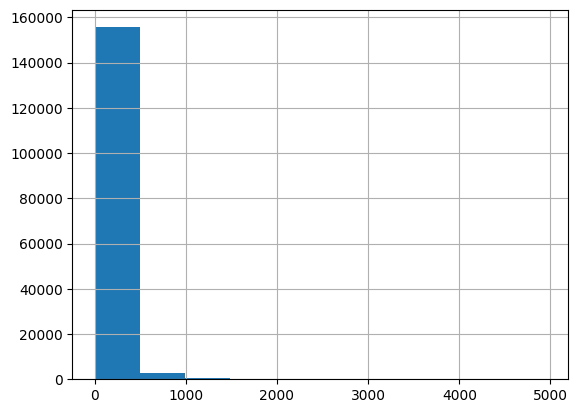

In [21]:
data = BuildDataset(df)
data.set_len_text()
data.list_text_size.hist()

In [22]:
data.list_text_size.mean(), data.list_text_size.median()

(94.7983514551892, 52.0)

Есть очень большие сообщения более 5 тыс. токенов, однако большинство меньше 100.

In [23]:
batch_size = 600

train_load = DataLoader(data, batch_size=batch_size, num_workers=0)
embeddings = {"emb": [], "target": []}
num = 0
for batch in train_load:
    num += 1
    print(f"{num}/{len(train_load)}", end="\r")
    with torch.no_grad():
        token = torch.squeeze(batch["input_ids"], dim=1).to("cuda:0")
        mask = torch.squeeze(batch["attention_mask"], dim=1).to("cuda:0")

        batch_embeddings = model(token, attention_mask=mask)

    embeddings["emb"].append(batch_embeddings[0][:, 0, :].cpu().numpy())
    embeddings["target"].append(batch["target"].cpu().numpy())

In [24]:
embed = embeddings["emb"]
target = embeddings["target"]

In [25]:
embed_np = np.concatenate(embed)
target_np = np.concatenate(target)

In [26]:
embed_np.shape, target_np.shape

((159292, 768), (159292,))

In [27]:
df_emb_toxic = pd.DataFrame(embed_np)
df_emb_toxic['target'] = target_np
df_emb_toxic.to_csv('data/df_emb_toxic.csv')

### Предсказываем с помощью логистической регрессии

In [28]:
new_df = pd.read_csv("data/df_emb_toxic.csv", index_col=0)

In [29]:
X = new_df.drop("target", axis=1)
y = new_df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y
)

In [30]:
model = LogisticRegression(max_iter=3000, penalty="l2", class_weight='balanced')
distributions = dict(C=uniform(loc=0, scale=10))

random_search_linear = RandomizedSearchCV(
    model, distributions, cv=5, n_jobs=5, n_iter=10, refit="f1", scoring="f1"
)
random_search_linear.fit(X_train, y_train)
print("Лучшие параметры:")
print(random_search_linear.best_params_)
print("Лучшая метрика на валидационных данных:")
print(random_search_linear.best_score_)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Используем catboost

In [31]:
model = CatBoostClassifier(
    iterations=10000,
    verbose=False,
    eval_metric="F1",
    task_type="GPU",
    devices="0",
    auto_class_weights="Balanced",
    boosting_type="Ordered",
    leaf_estimation_method="Newton",
)

param = {
    "l2_leaf_reg": [0.5, 2],
    "depth": [6],
    "learning_rate": [0.03, 0.003],
}

grid_search = model.grid_search(
    param,
    X=X_train,
    y=y_train,
    train_size=0.8,
    refit=True,
    cv=5,
    calc_cv_statistics=False,
    verbose=True,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.9833705798
bestIteration = 624
0:	loss: 0.9833706	best: 0.9833706 (0)	total: 7m 34s	remaining: 22m 44s
bestTest = 0.9833858173
bestIteration = 8594
1:	loss: 0.9833858	best: 0.9833858 (1)	total: 15m 3s	remaining: 15m 3s
bestTest = 0.9835369557
bestIteration = 621
2:	loss: 0.9835370	best: 0.9835370 (2)	total: 22m 30s	remaining: 7m 30s
bestTest = 0.9833646446
bestIteration = 6965
3:	loss: 0.9833646	best: 0.9835370 (2)	total: 30m	remaining: 0us
Estimating final quality...
Training on fold [0/5]


bestTest = 0.9840493136
bestIteration = 148
Training on fold [1/5]
bestTest = 0.981807809
bestIteration = 11
Training on fold [2/5]
bestTest = 0.9847832282
bestIteration = 324
Training on fold [3/5]
bestTest = 0.9828466995
bestIteration = 205
Training on fold [4/5]
bestTest = 0.9835113414
bestIteration = 860


Catboost показал себя лучше, чем логистическая регрессия, проверим алгоритм на тестовых данных. 

In [32]:
pred = model.predict(X_test)
f1_score(pred, y_test)

0.9401072705601908

## Вывод

Используя эмбединги берта, предобученного на токсичных комментариях и catboost удалось получить метрику f1 0.94.